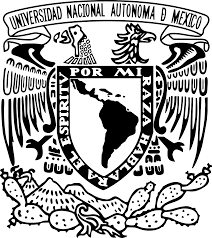

# PREDICT HOUSE PRICES USING REGRESSION MODELS

## Raúl Alberto Dufoo Barrios

# Introducción 

Se tienen dos bases de datos (una de entrenamiento y otra de prueba) con 79 variables explicativas que engloban caracteristicas de las viviendas, tales como: Zona en la que se encuentra la vivienda, tamaño del lote en ft cuadrados, estado general de la vivienda, mes en que se vendió , entre otras.
Con estas variables se busca predecir el precio final de cada casa, para esto se ajustarán modelos con la base de datos de entrenamiento y se verá como predice los datos de prueba.





In [28]:
from scipy import stats
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
#os.chdir('C:/Users/rdufoo/Desktop/Inteligencia Artificial')
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


In [4]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Se puede ver que existen variables que tienen valores perdidos, pero se cuenta con variables que si bien no captan la misma información si pueden tener cierta relación con las variables con muchos NaN, por ejemplo: para la variable PoolQc (Calidad de la piscina) podemos quedarnos con la variable PoolArea (Área de la piscina en pies cuadrados), para MiscFeature (Otras categorias no cubiertas en otras secciones)  podemos utilizar MiscVal (Valor de la característica miscelánea), para FireplaceQu utilizar fireplaces, para: GarageType, GarageYrBlt, GarageFinish, GarageQual y GarageCond se puede utilizar GarageCarsy GarageArea.
Existen categorias que no encontramos una variable similar (Alley y Fence) sin embargo solo tienen 91 y 281 valores diferentes de NA respectivamente por lo que no se puede pensar en algún tipo de imputación. 
Para las variables MasVnrType (Tipo de revestimiento de mampostería), MasVnrArea (Área de revestimiento de mampostería en pies cuadrados) y Electrical (Sistema eléctrico) no se encontró alguna variable similar y al tener pocos valores perdidos, se conservaron esas variables.

In [5]:
data_train = data_train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','BsmtFinType1'],axis=1)
data_test = data_test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','BsmtFinType1'],axis=1)


In [6]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5]),
 <a list of 36 Text major ticklabel objects>)

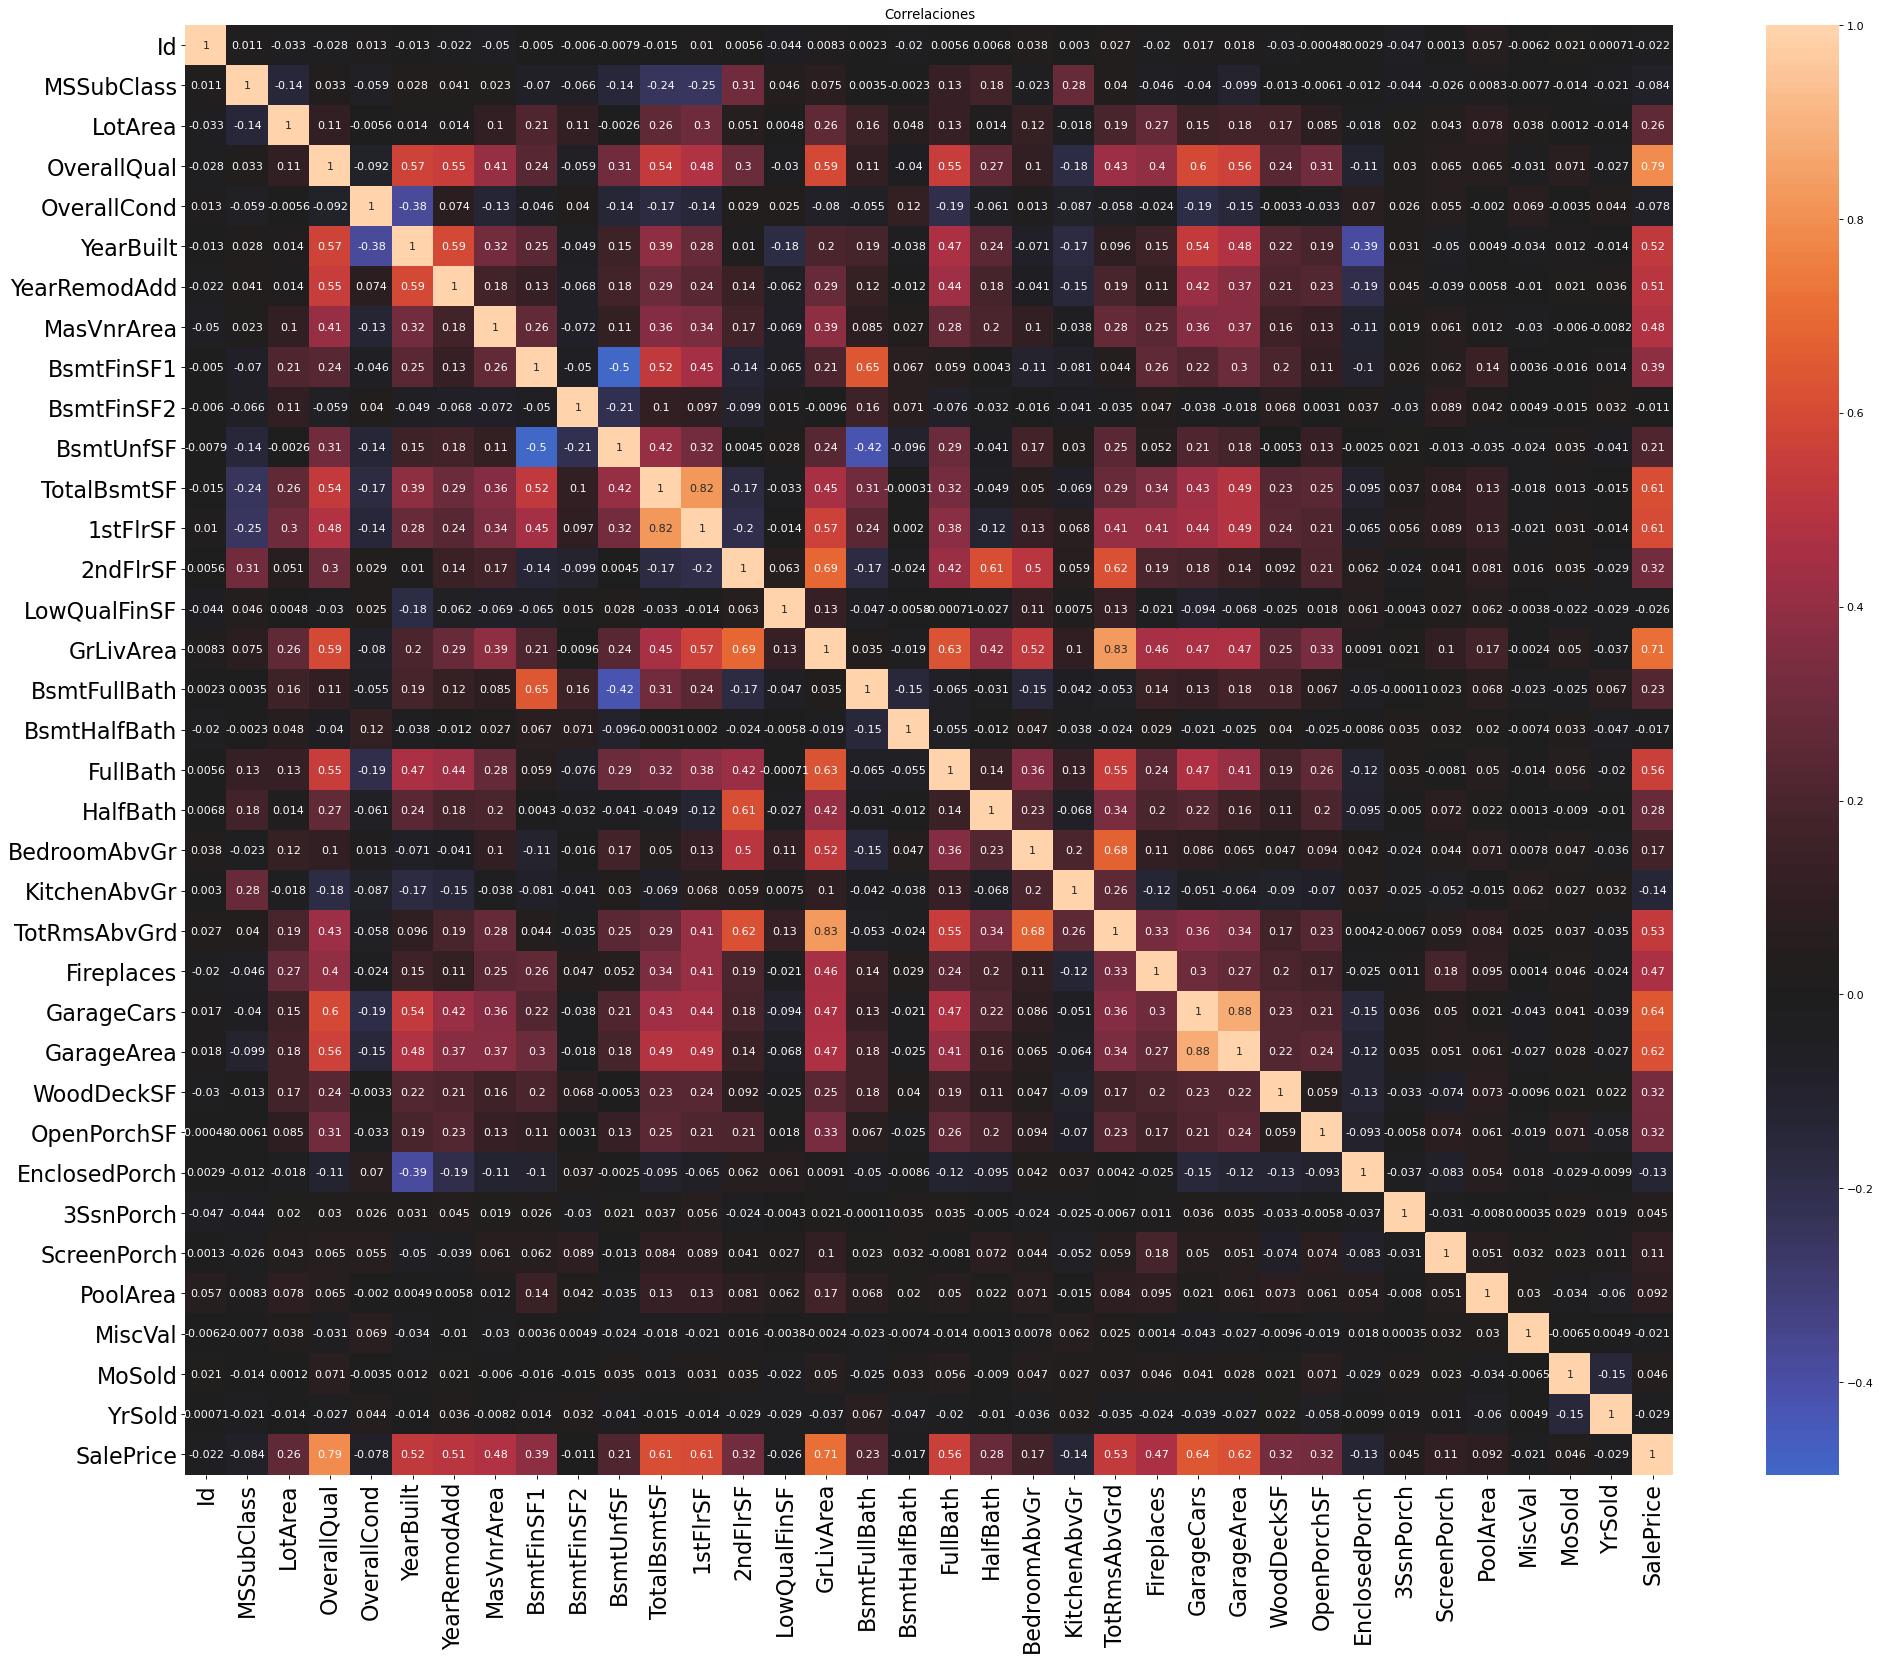

In [7]:
plt.figure(figsize=(30,24), dpi= 80)
sns.heatmap(data_train.corr(), xticklabels=data_train.corr().columns, yticklabels=data_train.corr().columns,center=0, annot=True)
plt.title("Correlaciones")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


Como primer modelo haremos una regresión lineal entre la variable precio de venta y la variable OverallQual (Califica el material general y el acabado de la casa), pues es la variable númerica que presenta una mayor correlación con la variable dependiente.

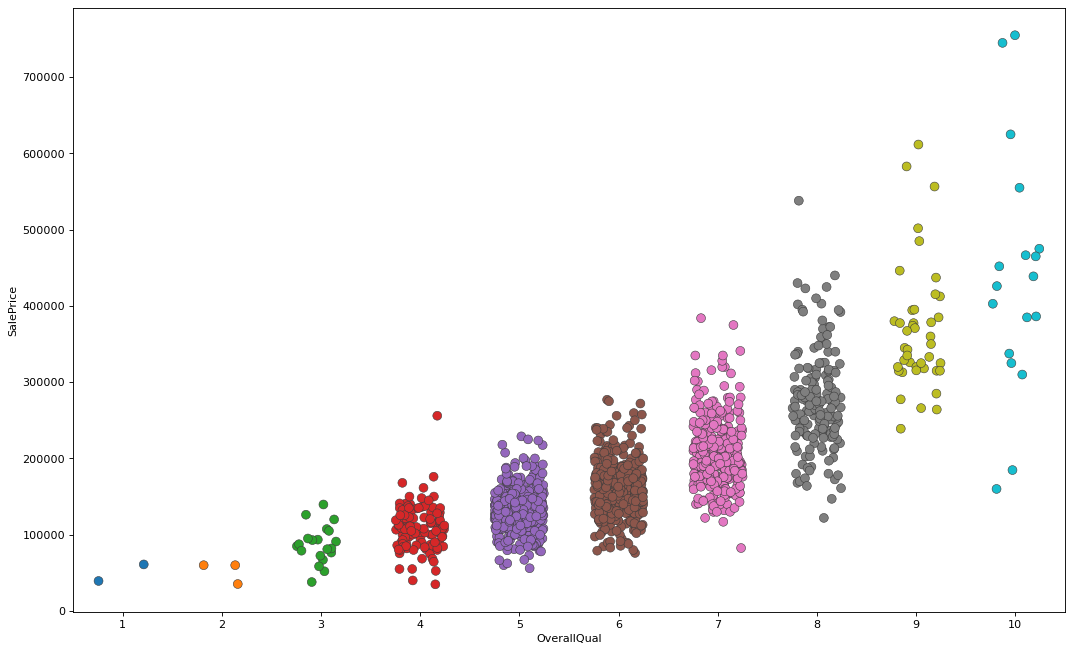

In [8]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)     
sns.stripplot(data_train.OverallQual, data_train.SalePrice,jitter=0.25, size=8, ax=ax, linewidth=.5)


In [44]:

X_cons = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=Y, exog=X_cons,)
modelo = modelo.fit()
print(modelo.summary())

intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2437.
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          2.19e-313
Time:                        03:29:30   Log-Likelihood:                -17827.
No. Observations:                1460   AIC:                         3.566e+04
Df Residuals:                    1458   BIC:                         3.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.621e+04   5756.407    -16.713      

,2.5%,97.5%
const,-107497.804409,-84914.354620
OverallQual,43630.293630,47241.311556


Se decidió ajusta una regresión lineal con el valor de la constante, si bien es cierto que tiene un valor de R cuadrado de 0.625 y el valor de ambas betas son significativas no es un tan buen modelo, pero veamos que pasa si ajustamos un modelo sin la constante.

In [45]:
X = data_train[["OverallQual"]]
Y = data_train["SalePrice"]

modelo = sm.OLS(endog=Y, exog=X,)
modelo = modelo.fit()
print(modelo.summary())

intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci


                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.879e+04
Date:                Thu, 14 Oct 2021   Prob (F-statistic):                        0.00
Time:                        03:29:36   Log-Likelihood:                         -17955.
No. Observations:                1460   AIC:                                  3.591e+04
Df Residuals:                    1459   BIC:                                  3.592e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

,2.5%,97.5%
OverallQual,29997.813276,30868.883826


Al ajustar un modelo sin la constante se tiene un valor de R cuadrada de 0.92 que este es un valor bastante alto para solo ser un modelo con una unica variable explicativa, que nos diriá por cada punto que aumente en su calificación el material general y el acabado de la casa el precio promedio de la casa aumentará cerca de 30,000. Si bien es un buen modelo probaremos con otros para incluir más variables y otro tipo de modelos.

In [59]:
X = data_train[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea","GarageCars","GarageArea"]]
Y = data_train["SalePrice"]

X_train = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=Y, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

#intervalos_ci = modelo.conf_int(alpha=0.05)
#intervalos_ci.columns = ['2.5%', '97.5%']
#intervalos_ci

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     775.0
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        04:26:26   Log-Likelihood:                -17496.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1453   BIC:                         3.504e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.027e+05   4903.994    -20.932      

Se ejecuto un modelo de regresión líneal con las variables que tienen una correlación mayor a 0.6 con el Precio de la Propiedad, sin embargo se tiene que algunas variables no son significativas  por lo cual se quitarán algunas variables para ver si se mejora el modelo, pues también en la correlación se tiene que las variables "GrLivArea" y "GarageCars" tienen una correlación alta (mayor a 0.8)

In [60]:
X = data_train[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea"]]
Y = data_train["SalePrice"]



X_train = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=Y, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1057.
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        04:30:28   Log-Likelihood:                -17550.
No. Observations:                1460   AIC:                         3.511e+04
Df Residuals:                    1455   BIC:                         3.514e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.09e+05   5042.479    -21.613      

array([2.84515070e+04, 2.57259269e+01, 1.66652627e+01, 4.59581787e+01])

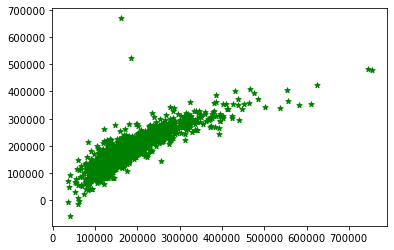

In [82]:
X = data_train[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea"]]
Y = data_train["SalePrice"]


lasso_model = Lasso(alpha=0.8,normalize=True, max_iter=1e6)
lasso_model.fit(X,Y)
predic_lasso = lasso_model.predict(X)
plt.scatter(Y, predic_lasso, label= "stars", color= "green",
            marker= "*", s=30)
lasso_model.coef_


array([2.84504178e+04, 2.57739038e+01, 1.66707446e+01, 4.59975678e+01])

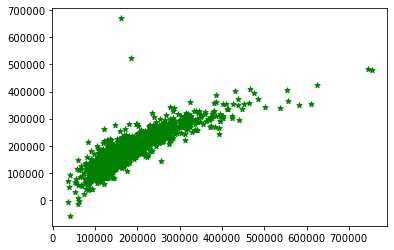

In [83]:
X = data_train[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea"]]
Y = data_train["SalePrice"]


ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X, Y)
predic_ridge = ridge_model.predict(X)
plt.scatter(Y, predic_ridge, label= "stars", color= "green",
            marker= "*", s=30)
ridge_model.coef_



In [ ]:
Si bien es cierto que los valores de las betas cambian utilizando un regresión líneal multiple, un modelo lasso y 
un modelo ridge, estos cambios no son "grandes", además que los valores predichos se parecen mucho, por lo cual, nos centraremos
en que modelo escoger para modelar, hasta el momento tenemos dos principales candidatos: aquel que solo tiene una variable
    dependiente (OverallQual) sin considerar la constante y aquel que considera cuatro variables, las cuales son:  "OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea.
Generaremos un nuevo modelo y veremos si podemos hacer que ajuste mejor.

In [104]:
X = data_train[["LotArea","MSSubClass","OverallQual","OverallCond","YearRemodAdd","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF", "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces"]]
Y = data_train["SalePrice"]



X_train = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=Y, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     288.5
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        06:33:11   Log-Likelihood:                -17398.
No. Observations:                1460   AIC:                         3.484e+04
Df Residuals:                    1440   BIC:                         3.494e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.458e+05    1.2e+05     -6.220   

Quitaremos las variables no significativas para el modelo de manera secuencial de acuero al p-value

In [ ]:
X = data_train[["LotArea","MSSubClass","OverallQual","YearRemodAdd","BsmtFinSF1","TotalBsmtSF", "1stFlrSF","2ndFlrSF","BsmtFullBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces"]]
Y = data_train["SalePrice"]

#Orden en que se quitaron : "BsmtUnfSF","BsmtFinSF2","OverallCond","BsmtHalfBath","LowQualFinSF","GrLivArea"

X_train = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=Y, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Aplicando un modelo lasso y ridge con esas variables se obtiene:

array([ 4.34489126e-01, -1.70774097e+02,  2.20190297e+04,  3.72039823e+02,
        1.44866680e+01,  1.13323213e+01,  4.86077551e+01,  4.11510155e+01,
        9.23899015e+03,  1.11834176e+04,  6.00778456e+03, -1.05665661e+04,
       -1.77945351e+04,  5.28584181e+03,  4.47497893e+03])

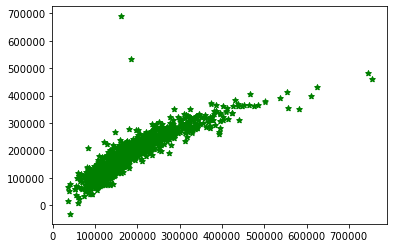

In [111]:
X = data_train[["LotArea","MSSubClass","OverallQual","YearRemodAdd","BsmtFinSF1","TotalBsmtSF", "1stFlrSF","2ndFlrSF","BsmtFullBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces"]]
Y = data_train["SalePrice"]


lasso_model = Lasso(alpha=0.8,normalize=True, max_iter=1e6)
lasso_model.fit(X,Y)
predic_lasso = lasso_model.predict(X)
plt.scatter(Y, predic_lasso, label= "stars", color= "green",
            marker= "*", s=30)
lasso_model.coef_


ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X, Y)
predic_ridge = ridge_model.predict(X)
plt.scatter(Y, predic_ridge, label= "stars", color= "green",
            marker= "*", s=30)
ridge_model.coef_



array([ 4.34489126e-01, -1.70774097e+02,  2.20190297e+04,  3.72039823e+02,
        1.44866680e+01,  1.13323213e+01,  4.86077551e+01,  4.11510155e+01,
        9.23899015e+03,  1.11834176e+04,  6.00778456e+03, -1.05665661e+04,
       -1.77945351e+04,  5.28584181e+03,  4.47497893e+03])

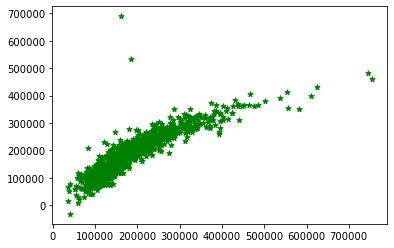

In [120]:
X = data_train[["LotArea","MSSubClass","OverallQual","YearRemodAdd","BsmtFinSF1","TotalBsmtSF", "1stFlrSF","2ndFlrSF","BsmtFullBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces"]]
Y = data_train["SalePrice"]

ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X, Y)
predic_ridge = ridge_model.predict(X)
plt.scatter(Y, predic_ridge, label= "stars", color= "green",
            marker= "*", s=30)
ridge_model.coef_


Sin embargo, tampoco se notan cambios significativos, además el incorporar más variables no ayuda a que mejore mucho nuestro 
modelo, por lo que llegamos a la conclusión que la variable más importante para definir el precio de venta de una vivienda
es OverallQual, sin embargo, si se quieren incluir más variables para poder explicar mejor el modelo (sin incluir muchas
para tener un modelo parsimonioso y sin sobre ajuste), consideramos que las variables que se podrían agregar son: 
    "OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea".
Finalmente con estas ultimas con el modelo Ridge que considere estas ultimas cuatro variables haremos la predicción sobre
los datos de pruebas y compararemos con los valores "reales".

array([2.84504178e+04, 2.57739038e+01, 1.66707446e+01, 4.59975678e+01])

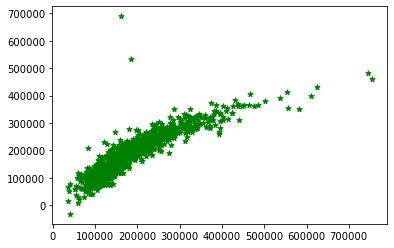

In [122]:
X = data_train[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea"]]
Y = data_train["SalePrice"]


ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X, Y)
Z= data_test[["OverallQual","TotalBsmtSF","1stFlrSF","GrLivArea"]]
predic_ridge = ridge_model.predict(Z)
plt.scatter(Y, predic_ridge, label= "stars", color= "green",
            marker= "*", s=30)
#ridge_model.coef_


Que podemos ver tiene un buen ajuste de los datos (muy similar a los datos de entrenamiento).